In [49]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader
import os
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torch import nn, optim
from torch.nn import functional as F
import sys
from tqdm import tqdm
import time
import copy
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from PIL import Image
import torch.cuda.amp as amp
import functools
import types
import seaborn as sns
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline


from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import optuna





In [55]:
dataset_path = "D:\\ASD_FACE"

In [36]:
def get_data(data_dir, batch_size, input_size=299, train=False):
    if train:
        train_datagen = ImageDataGenerator(
            rescale=1.0/255.0,          
            rotation_range=30,          
            width_shift_range=0.2,    
            height_shift_range=0.2,    
            shear_range=0.2,             
            zoom_range=0.2,               
            horizontal_flip=True,        
            fill_mode='nearest'           
        )


        train_data = train_datagen.flow_from_directory(
            os.path.join(data_dir, "train"),
            target_size=(input_size, input_size),
            batch_size=batch_size,
            class_mode='binary' 
        )
        train_size = train_data.samples

        return train_data, train_size

    else:
        eval_datagen = ImageDataGenerator(rescale=1.0/255.0)

        val_data = eval_datagen.flow_from_directory(
            os.path.join(data_dir, "valid"),
            target_size=(input_size, input_size),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False  
        )
        val_size = val_data.samples

        test_data = eval_datagen.flow_from_directory(
            os.path.join(data_dir, "test"),
            target_size=(input_size, input_size),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False 
        )
        test_size = test_data.samples

        return val_data, test_data, val_size, test_size


In [56]:
(train_data, train_data_len) = get_data(dataset_path, batch_size = 32, train=True)
(val_data, test_data, valid_data_len, test_data_len) = get_data(dataset_path, batch_size =32, train=False)

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [24]:
def build_xception_model(input_shape, optimizer):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
    )
    
    return model


def f1_score(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())


In [30]:
input_shape = (299, 299, 3)
optimizer = Adagrad(learning_rate=0.001)
model = build_xception_model(input_shape, optimizer)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,911,081 (83.58 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [39]:
def train_and_eval_model(model, train_data, val_data, batch_size=32, epochs=10, patience=5, model_save_path='best_model.h5'):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        filepath=model_save_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return history


In [57]:
history = train_and_eval_model(
    model=model,
    train_data=train_data,
    val_data=val_data,
    batch_size=32,
    epochs=50,
    patience=5,
    model_save_path='xception_best_model.keras'
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6877 - f1_score: 16.0573 - loss: 0.5753 - precision: 0.6890 - recall: 0.6956
Epoch 1: val_loss improved from inf to 0.55349, saving model to xception_best_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6878 - f1_score: 16.0520 - loss: 0.5752 - precision: 0.6890 - recall: 0.6955 - val_accuracy: 0.7700 - val_f1_score: 11.5428 - val_loss: 0.5535 - val_precision: 0.7455 - val_recall: 0.8200
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6781 - f1_score: 15.6573 - loss: 0.5927 - precision: 0.6727 - recall: 0.6776
Epoch 2: val_loss did not improve from 0.55349
80/80 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6781 - f1_score: 15.6545 - loss: 0.5925 - precision: 0.6729 - recall: 0.6775 - val_accuracy: 0.7400 - val_f1_score: 11.7931 - val_loss: 0.5610 - val_precision: 0.7069 - val_recall: 0.8200
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6973 - f1_score: 16.0626 - loss: 0.5

In [58]:
def build_model(input_shape, optimizer, learning_rate):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    if optimizer == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == "adagrad":
        opt = Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

 
    model = Model(inputs, outputs)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

In [59]:
def objective(trial):

    optimizer = trial.suggest_categorical("optimizer", ["adam", "adagrad"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2) 
    input_shape = (299, 299, 3)
    model = build_model(input_shape, optimizer, learning_rate)

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
    )

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,  
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0 
    )


    return min(history.history['val_loss'])

In [60]:
study = optuna.create_study(direction="minimize")  
study.optimize(objective, n_trials=5) 

[I 2024-12-01 12:23:04,062] A new study created in memory with name: no-name-f77f7548-120e-4b2f-82bf-759cbe020491


Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


[I 2024-12-01 12:41:59,606] Trial 0 finished with value: 0.5367881059646606 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.008527480442022449}. Best is trial 0 with value: 0.5367881059646606.


Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


[I 2024-12-01 13:00:40,239] Trial 1 finished with value: 0.5260069370269775 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.0012804945934927515}. Best is trial 1 with value: 0.5260069370269775.


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2024-12-01 13:11:01,990] Trial 2 finished with value: 0.5556020736694336 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0034788077947715762}. Best is trial 1 with value: 0.5260069370269775.


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.


[I 2024-12-01 13:27:41,163] Trial 3 finished with value: 0.5402222871780396 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.008847139426124431}. Best is trial 1 with value: 0.5260069370269775.


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2024-12-01 13:38:02,854] Trial 4 finished with value: 0.5384648442268372 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.006790014238496976}. Best is trial 1 with value: 0.5260069370269775.


In [61]:
print("Best Trial:")
print(f"Optimizer: {study.best_trial.params['optimizer']}")
print(f"Learning Rate: {study.best_trial.params['learning_rate']}")
print(f"Validation Loss: {study.best_value}")

Best Trial:
Optimizer: adagrad
Learning Rate: 0.0012804945934927515
Validation Loss: 0.5260069370269775


In [62]:
best_params = study.best_trial.params

best_optimizer = best_params['optimizer']
best_learning_rate = best_params['learning_rate']

print("Best Optimizer:", best_optimizer)
print("Best Learning Rate:", best_learning_rate)

best_model = build_model((299, 299, 3), optimizer=best_optimizer, learning_rate=best_learning_rate)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='xception_best_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


history = best_model.fit(
    train_data,                  
    validation_data=val_data,    
    epochs=20,                   
    batch_size=32,               
    callbacks=[early_stopping, model_checkpoint]
)

Best Optimizer: adagrad
Best Learning Rate: 0.0012804945934927515
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5243 - loss: 0.9971 - precision: 0.5422 - recall: 0.5198
Epoch 1: val_loss improved from inf to 0.60181, saving model to xception_best_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5246 - loss: 0.9958 - precision: 0.5423 - recall: 0.5201 - val_accuracy: 0.7000 - val_loss: 0.6018 - val_precision: 0.7381 - val_recall: 0.6200
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6036 - loss: 0.7322 - precision: 0.5884 - recall: 0.5691
Epoch 2: val_loss improved from 0.60181 to 0.59172, saving model to xception_best_model.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6037 - loss: 0.7318 - precision: 0.5888 - recall: 0.5696 - val_accuracy: 0.6900 - val_loss: 0.5917 - val_precision: 0.6610 - val_recall: 0.7800
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6187 - loss: 0.6779 - precision: 0.6303 - recall: 0

In [69]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

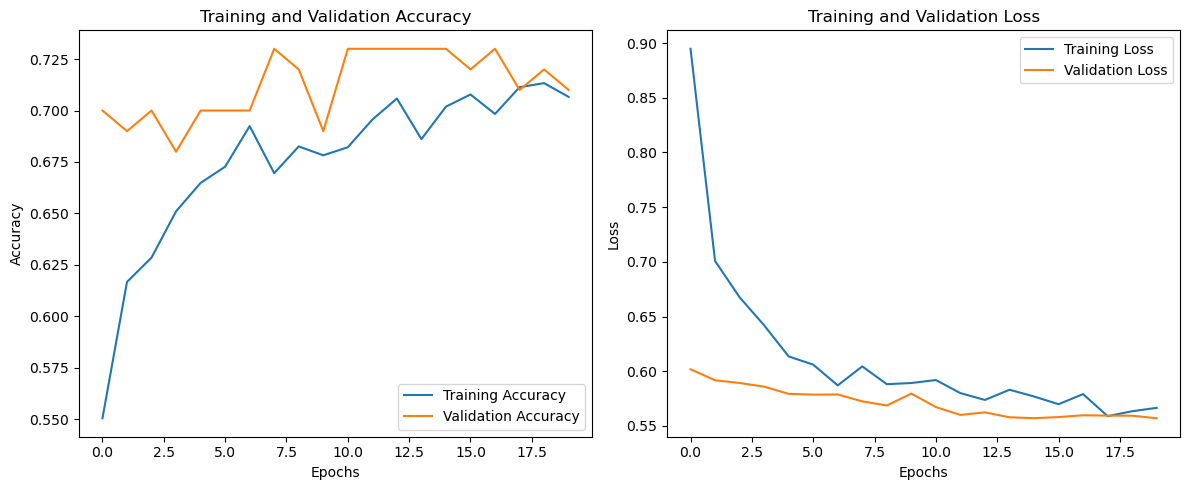

In [70]:
plot_training_history(history)

In [66]:
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_data)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7879 - loss: 0.5221 - precision: 0.4042 - recall: 0.4808
Test Loss: 0.5313
Test Accuracy: 0.7633
Test Precision: 0.7842
Test Recall: 0.7267
